In [1]:
import pandas as pd

# Load only first 50k rows
df = pd.read_csv("vaers_data_30k.csv")

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (50000, 16)
   VAERS_ID  AGE_YRS SEX STATE  YEAR     VAX_TYPE            VAX_MANU  \
0   2014312     43.0   M    CA  2022  ['COVID19']         ['MODERNA']   
1   2674619     64.0   F   NaN  2021  ['COVID19']         ['MODERNA']   
2   1033357     47.0   F    WV  2021  ['COVID19']         ['MODERNA']   
3   1131403     68.0   F    MA  2021  ['COVID19']         ['MODERNA']   
4   2477972     69.0   F    OK  2022     ['FLU4']  ['SANOFI PASTEUR']   

  VAX_DOSE_SERIES     DIED L_THREAT  DISABLE   RECOVD  \
0           ['3']  Unknown  Unknown  Unknown      Yes   
1           ['2']  Unknown  Unknown  Unknown       No   
2         ['UNK']  Unknown  Unknown  Unknown  Unknown   
3    ['UNK', '2']  Unknown  Unknown  Unknown  Unknown   
4      ['1', '2']  Unknown  Unknown  Unknown      Yes   

                                       symptoms_list age_bucket any_serious  \
0  ['cardiac flutter', 'chest discomfort', 'chest...      18-49     Unknown   
1  ['joint pain', 'chills', 'head

Dataset shape: (50000, 16)

Columns: ['VAERS_ID', 'AGE_YRS', 'SEX', 'STATE', 'YEAR', 'VAX_TYPE', 'VAX_MANU', 'VAX_DOSE_SERIES', 'DIED', 'L_THREAT', 'DISABLE', 'RECOVD', 'symptoms_list', 'age_bucket', 'any_serious', 'symptoms_normalized']

Outcome counts:
            DIED  L_THREAT  DISABLE  RECOVD  any_serious
No           NaN       NaN      NaN   15163          NaN
Unknown  49165.0   49296.0  49021.0   20024      47704.0
Yes        835.0     704.0    979.0   14813       2296.0


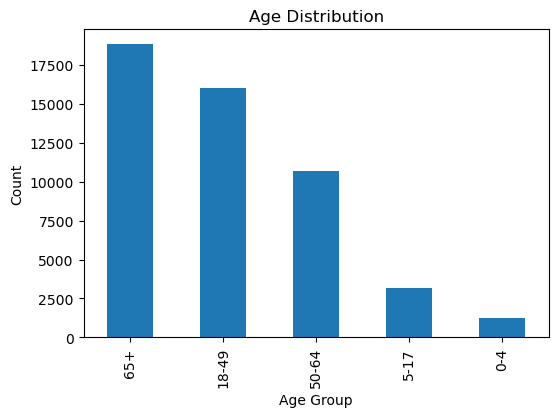

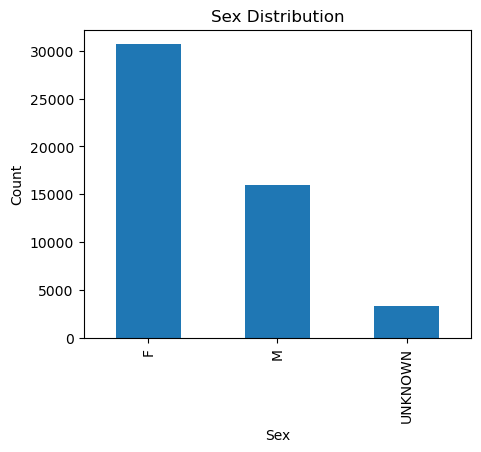

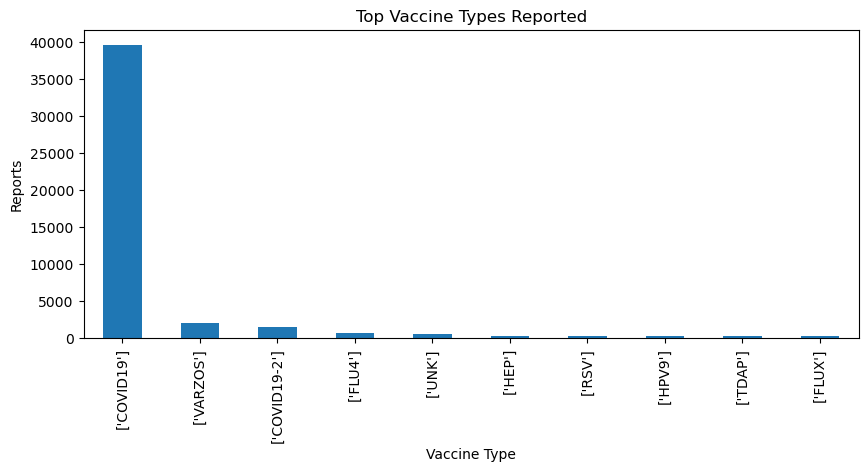

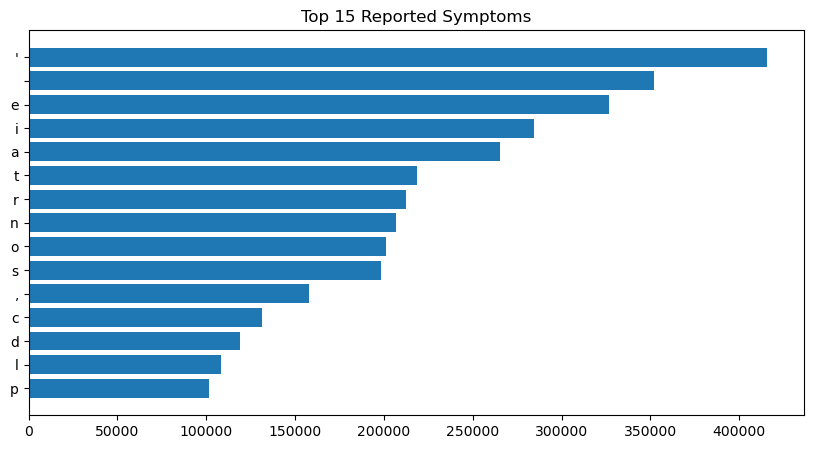

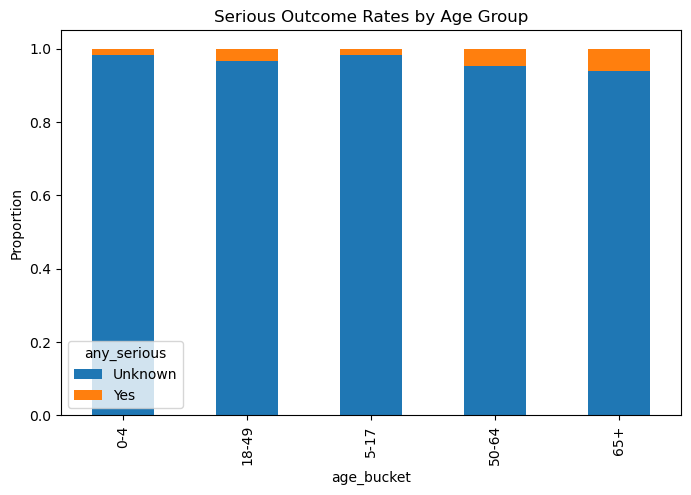

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
#  EDA Section

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Outcome counts 
print("\nOutcome counts:")
print(df[["DIED", "L_THREAT", "DISABLE", "RECOVD", "any_serious"]].apply(pd.Series.value_counts))

# Age distribution
plt.figure(figsize=(6,4))
df["age_bucket"].value_counts().plot(kind="bar")
plt.title("Age Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

# Sex distribution
plt.figure(figsize=(5,4))
df["SEX"].value_counts().plot(kind="bar")
plt.title("Sex Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

# Top vaccine types
plt.figure(figsize=(10,4))
df["VAX_TYPE"].value_counts().head(10).plot(kind="bar")
plt.title("Top Vaccine Types Reported")
plt.xlabel("Vaccine Type")
plt.ylabel("Reports")
plt.show()

# Top symptoms 
all_symptoms = [s for sublist in df["symptoms_list"] for s in sublist]
symptom_counts = Counter(all_symptoms)
top_symptoms = pd.DataFrame(symptom_counts.most_common(15), columns=["Symptom", "Count"])

plt.figure(figsize=(10,5))
plt.barh(top_symptoms["Symptom"], top_symptoms["Count"])
plt.title("Top 15 Reported Symptoms")
plt.gca().invert_yaxis()
plt.show()

# Serious outcomes by age group 
serious_by_age = df.groupby("age_bucket")["any_serious"].value_counts(normalize=True).unstack().fillna(0)
serious_by_age.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Serious Outcome Rates by Age Group")
plt.ylabel("Proportion")
plt.show()


In [3]:
print(df.columns.tolist())

['VAERS_ID', 'AGE_YRS', 'SEX', 'STATE', 'YEAR', 'VAX_TYPE', 'VAX_MANU', 'VAX_DOSE_SERIES', 'DIED', 'L_THREAT', 'DISABLE', 'RECOVD', 'symptoms_list', 'age_bucket', 'any_serious', 'symptoms_normalized']


In [4]:
df["AGE_YRS"] = df["AGE_YRS"].fillna("Unknown")


In [5]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from tqdm import tqdm

print("Dataset shape:", df.shape)

#  Load SBERT MiniLM model

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
# Prepare texts
texts = df["symptoms_normalized"].astype(str).tolist()

#  Generate embeddings

batch_size = 512  
embeddings = model.encode(
    texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # helpful for clustering
)

print("Embeddings shape:", embeddings.shape)  
# Save embeddings
np.save("sbert_minilm_embeddings_split.npy", embeddings)
print("✅ SBERT embeddings saved for split")



Dataset shape: (50000, 16)


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Embeddings shape: (50000, 384)
✅ SBERT embeddings saved for split


In [6]:
import joblib
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Load dataset
df = pd.read_csv("vaers_sample_cleaned.csv")

# Target variable
y = df["any_serious"].apply(lambda x: 1 if x == "Yes" else 0).values

# TF-IDF on symptom text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["symptoms_normalized"].fillna(""))

# Save sparse features (optional)
sparse.save_npz("features_sparse.npz", X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression
clf = LogisticRegression(class_weight="balanced", max_iter=1000, n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Save model + vectorizer
joblib.dump(clf, "logreg_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("✅ Model and vectorizer saved")


              precision    recall  f1-score   support

           0       0.99      0.88      0.93    233982
           1       0.26      0.85      0.40     11069

    accuracy                           0.88    245051
   macro avg       0.62      0.87      0.67    245051
weighted avg       0.96      0.88      0.91    245051

ROC-AUC: 0.9432830107235741
✅ Model and vectorizer saved
